TensorFlow provides three ways to code up neural networks. The first is a graph mode where you can define and carry out calculations on a computational graph. The second is Eager mode which is more dynamic in nature. In Eager more you do not need to define a computational graph to run the code network and it allow for quick prototyping. The third mode is the subject of this notebook called the Keras API. Keras was a high level prototyping framework for deep learning. TensorFlow adopted keras into it's ecosystem due to its ease of use. TensorlFlow now provides Keras as part of it main platform. 

Keras is possibly the easiest deep learning framework to learn. As you will see over the course of this notebook, Keras is intuitive and its well integrated with  with TensorFlow. 

We will look at the following topics over the course of this notebook- 

1) Building a MNIST model in Keras <br>
2) Saving and loading models <br>
3) Import a pretrained VGG 16 model in Keras <br> 
4) Getting intermediate layer outputs <br> 

We first start by building a MNIST model

## 1) Building a MNIST model in Keras 

The MNIST dataset is a image dataset of handwritten digits. These images are grayscale images and range from digits 0 to 9. The classification task is to identify which digit based on the image. MNIST is a standard benchmarking dataset that is easy to train since the image sizes are small (28 X 28).

We start with the import statements below. Notice we are importing layers from keras directly. As of TensorFlow 2.0 all TensorFlow layers are now by default keras layers. Hence, they can be used to construct TensorFlow or Keras based networks.




In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Flatten, Conv2D, InputLayer
from tensorflow.keras import Model
from tensorflow.keras import backend as k 

import imagenet_classes as ic 

# checking the version of tensorflow
print(tf.__version__) 


# In TensorFlow 2.0 this is the way
# to activate eager execution mode
# and ONLY this way. 
tf.executing_eagerly()


2.0.0


True

We have also included tf.executing_eagerly() since we want Eager execution turned on so we can perform tensor calculations when needed.

The first line of the code below imports the mnist dataset from keras.datasets. The load data function allows us to acquire th test and train sets. Next we normalize the dataset by dividing it by 255 since these are grayscale images. 

The x_train and x_test objects are TensorFlow eager tensors containing 60,000 images in the training set and 10,000 images. TensorFlow and Keras require the tensor dimensions of the form  (Number of images, Height, Width, Number of channels ), therefore we need to add an extra dimension to account for the channel. These channels are added through tf.newaxis. 
We print the final shape of the training set and the test set to check if the dimensions are proper.


In [2]:
# get minst data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test =  x_test / 255.0

# add channel 
# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print("training set shape {}".format(x_train.shape))
print("test set shape {}".format(x_test.shape))



training set shape (60000, 28, 28, 1)
test set shape (10000, 28, 28, 1)


A Keras model is defined using the "Sequential" method from Keras.models. We provide Sequential with a list of layers which are compiled into the model. The first layer we are providing is the InputLayer. We provide this layer with information about the input image's shape and a name for the layer. It is a good habit to provide names to each Keras layer since it makes it more intuitive to track layers and identify layers when we are trying to get layer-wise output. 

The next layer is a 2D convolution layer with 32 filters. Each convolution filter is 3X3 in shape with Relu activation and padding as "same". We specific the kernel size which is the size of the convolutional filter.   The "same" padding ensures that the output of the convolution layer is a 28 X 28 size feature map which is the size of the original image. You can change the padding to "valid" which will reduce the size of the feature map size to 26 X 26. For more information on padding check out the [Keras documentation on convolutional layers](https://keras.io/layers/convolutional/). 

The Flatten layer takes the convolutional layer and lays it out N X 1 vector. The convolution layer takes a 28 X 28 image and outputs a 28 X 28 X 32 matrix where we have 32 filters of size 28 X 28. Flatten takes this matrix and makes it into a  (28 X 28 X 32 ) X 1 vector which is a 25088 X 1 vector. We flatten a convolutional layer so that we can us dense layers to get an output. 

Next, we have a dense layer with 128 nodes. This layers take the flatten layer as an input and uses Relu activation. Following this we have another dense layer with 10 nodes which acts the output layer. We use a softmax activation to convert output values to probability values. 

We compile the model where we specify the type of loss, optimizer type, and the metric. We use a sparse categorical cross entropy since our labels are single digits 0 to 9. If we had used categorical cross entropy we would have to one hot encode the labels. The "adam" optimizer is usually a good optimizer to go with when we are solving a classification problem. For this network, honestly the type of optimizer does not matter, since the network is small.  

In the last line we run model.fit() to train the model. We provide the batch size we want to use for training and also the number of epochs. We are running the training for only 1 epoch since this is a simple example.

While training Keras will output the loss, the accuracy and the estimated time to complete the training. If the loss does not start decreasing as you are training the network or alternatively the accuracy does not keep increasing then stop the code, modify the network and start retraining. The accuracy will be reported between 0 and 1 so for example a value of 0.40 would be 40% accuracy. Typically at the end of each epoch the loss should reduce significantly and in subsequent epochs should come down close to 0. 


In [3]:



model = tf.keras.models.Sequential(

    [   InputLayer( input_shape=( 28,28,1), name="input"),
        Conv2D(filters=32, kernel_size=3, activation='relu',padding='same',name="conv1" ),
        Flatten(),
        Dense(128, input_shape=(25088,1), name="fc1", activation="relu"),
        Dense(10, input_shape=(128,1), name="fc2", activation="softmax"),
    ]
)


model.compile(loss= "sparse_categorical_crossentropy", 
                  optimizer="adam" , 
                  metrics=['accuracy'])

preds = model.fit(x_train, y_train, batch_size=32, epochs=1)



Train on 60000 samples
60000/60000 [==============================] - 28s 470us/sample - loss: 0.1354 - accuracy: 0.9597


Keras provides a useful tool to take a look at model called model.summary(). For large models this comes in handy since we can see the various operations that form the model. 


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               3211392   
_________________________________________________________________
fc2 (Dense)                  (None, 10)                1290      
Total params: 3,213,002
Trainable params: 3,213,002
Non-trainable params: 0
_________________________________________________________________



Once the model finished training it can be used on single examples using model.predict(). We run the predict function on an example image from the training set. The output is an array of 10 numbers. Each number represents the probability of each class and lies between 0 and 1. Running numpy's argmax on the array tells the max index is 5 meaning the image be of the number 5. We check this by displaying the image and sure enough we see the image represents the digit 5. 




softmax output max index 5


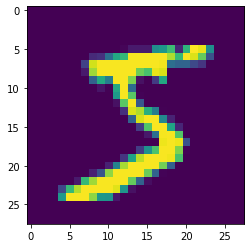

In [5]:

single_example = x_train[0].reshape(1,28,28,1)
softmax_output = model.predict(single_example)
print("softmax output max index {}".format(np.argmax(softmax_output)))

# display image 
plt.imshow(single_example.reshape(28,28))

## 2) Saving and loading models
Once we have trained a model it would be useful to save it. Keras offers the "save" and "load" commands to save and load models. The models ideally should be saved in an .h5 file. Below, we give the model a name and the .h5 extension to save the model. We then delete the model, reload and run summary and predict another image with it to show that loading the model works. 



In [6]:
model.save("keras_mnist_model.h5")
del model 


In [7]:
mnist_model = tf.keras.models.load_model("keras_mnist_model.h5")
mnist_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               3211392   
_________________________________________________________________
fc2 (Dense)                  (None, 10)                1290      
Total params: 3,213,002
Trainable params: 3,213,002
Non-trainable params: 0
_________________________________________________________________


softmax output max index 5


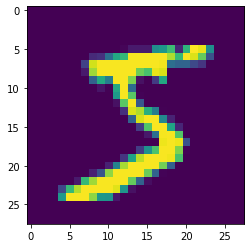

In [8]:
mnist_model.predict(single_example)
softmax_output = mnist_model.predict(single_example)
print("softmax output max index {}".format(np.argmax(softmax_output)))

# display image 
plt.imshow(single_example.reshape(28,28))

We ran the model on the same example to show that loaded model provides the same output as the saved model. 

Next, we will look at importing existing models provided by Keras and how to run prediction on them. 

## 3) Importing and working with VGG 16 model 
 In this section we will import a vgg 16 model and run prediction on a single example to show how to work with pre-trained models. It is possible to train a pre-trained model based on custom data but we will keep that for a separate tutorial. This exercise is there to get you comfortable with Keras. 
 
 We import the VGG 16 from the keras.applications package. The include top argument is set to true since we are importing both the feature extractor part, which is the convolutional layers and the classifier part, which is the last dense layer named prediction. The weights are imagenet since imagenet can predict 1000 classes.


In [9]:
# import a vgg 16 model 
vgg16_model = tf.keras.applications.VGG16(include_top=True,
                                           weights='imagenet')

# layers in a vgg16 model
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Once we have the model we need to prepare out example image. VGG 16 takes an image size of (224,224,3) meaning it takes an RGB image of size 224 X 224. We import out image and rescale to this size. 



In [10]:
cat_img = plt.imread("cat_example.jpg")
cat_img_tf = tf.convert_to_tensor(cat_img)
cat_img_reshaped = tf.image.resize(cat_img_tf, size=[224,224])
cat_img_reshaped = tf.reshape(cat_img_reshaped,[1, 224, 224,3])
# reshaped image 
print("cat image size reshaped {}" .format(cat_img_reshaped.shape))

cat image size reshaped (1, 224, 224, 3)


Now that we have resized image, we will run model.predict to predict the image's class. 

In [11]:
softmax_output = vgg16_model.predict(cat_img_reshaped)
class_index = np.argmax(softmax_output)
print("class index {}".format(class_index))


class index 285


We imported a python file with imagenet class names and in the code below we put the value of the class index to see what is the output class. 

In [12]:
print("imagenet class of our output is {}".format(ic.imagenet_classes[class_index]))
      

AttributeError: module 'imagenet_classes' has no attribute 'imagenet_classes'

The VGG 16 model predicts that the image represents an egyptian cat. The cat in the image looks similar to an egyptian mau cat hence the mode makes the guess. You can replace the image with some other image to test out the accuracy of the output. 

Next, we will look at how to get intermediate layer outputs. 

## 4) layer output 

There are times when we need to access acquire the output of the neural network in the intermediate layers. For instance, if we want to understand what is happening in the network we need to visualize the feature maps generated by the convolutional layers or for instance the results we achieve in the dense layer. It is possible to write functions in Keras to get the output of the network in the intermediate layers. This is where naming out layers comes in handy. 


We design a function using the Model object from tensorflow.keras. Model takes our mnist_model inputs as inputs and the outputs as the output of the convolutional layer. If we have done this right, then we should have 1 X 28 X 28 X 32 size tensor. Printing conv_layer_output confirms that we have the correct layer. 



In [ ]:
mnist_layer_output  = Model(inputs= mnist_model.input, outputs=mnist_model.get_layer("conv1").output)
conv_layer_output = mnist_layer_output(single_example)
print(conv_layer_output.shape)



What if we want the first dense layer from the mnist model. We write -

In [ ]:
mnist_fc_output  = Model(inputs= mnist_model.input, outputs=mnist_model.get_layer("fc1").output)
fc_layer_output = mnist_fc_output(single_example)
print(fc_layer_output.shape)


The fc output is a tensor with 128 elements. We can print the values in an array by calling on numpy


In [ ]:
fc_layer_output.numpy()

##  Conclusion 

 We have covered some of the basic functionalities of Keras in this notebook. As you can see, Keras is intuitve and easy to use. It is reduces the steep learning curve of other deep learning frameworks and integrates well with TensorFlow. This notebook is by no means a exhaustive exploration of all the tools in Keras but meant to be a starting point to working with it.We will cover many more Keras functionalities as we proceed through the course.